# French Motor Third-Party Liability Claims
# Problem set 3 analysis

## Introduction
This notebook contains the analysis for the French Motor Third-Party Liability Claims dataset. 
We aim to improve the risk model presented in
https://glum.readthedocs.io/en/latest/tutorials/glm_french_motor_tutorial/glm_french_motor.html# 
and learn how to work with model pipelines.

## Background:
Insurance claims are requests made by a policy holder to an insurance company for compensation in the event of a covered loss. When modeling these claims, the goal is often to estimate, per policy, the total claim amount per exposure unit. (i.e. number of claims  average amount per claim per year). This amount is also referred to as the pure premium.

Two approaches for modeling this value are:

- Modeling the total claim amount per exposure directly
- Modeling number of claims and claim amount separately with a frequency and a severity model

In this notebook, we will start with the Tweedie model for pure premium as the benchmark model. We will then improve the parametric model by adding more flexibility and applying LGBM Regressor. Finally, we also train a LGBM frequency and severity model and compare the fit relative to the other
models.

## Set up

In [561]:
# Problem set 3 analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.stats
from dask_ml.preprocessing import Categorizer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc
from lightgbm import LGBMRegressor
from glum import GeneralizedLinearRegressor
from glum import TweedieDistribution
from data import _sample_split, _load_transform


## Load the data

Some important notes about the dataset post-transformation:

- Total claim amounts are aggregated per policy
- For ClaimAmountCut, the claim amounts (pre-aggregation) were cut at 100,000 per single claim. The authors choose to use this amount rather than the raw ClaimAmount. (100,000 is the 0.9984 quantile but claims > 100,000 account for 25% of the overall claim amount)
- The authors aggregate the total claim amounts per policy
- ClaimNb is the total number of claims per policy with claim amount greater zero
- VehPower, VehAge, and DrivAge are clipped and/or digitized into bins so that they can be used as categoricals later on

In [357]:
df = load_transform()
with pd.option_context('display.max_rows', 10):
    display(df)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountCut
0,1,0,0.10000,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0
1,3,0,0.77000,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0
2,5,0,0.75000,B,6,1,5,50,B12,Diesel,54,R22,0.0,0.0
3,10,0,0.09000,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0
4,11,0,0.84000,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0,0.00274,E,4,0,5,50,B12,Regular,3317,R93,0.0,0.0
678009,6114327,0,0.00274,E,4,0,4,95,B12,Regular,9850,R11,0.0,0.0
678010,6114328,0,0.00274,D,6,1,4,50,B12,Diesel,1323,R82,0.0,0.0
678011,6114329,0,0.00274,B,4,0,5,50,B12,Regular,95,R26,0.0,0.0


## Create train test split

In [383]:
df = _sample_split.create_sample_split(df, 'IDpol', 0.8)

# Count number true for sample
training_count = df['sample'].value_counts().iloc[0]
testing_count = df['sample'].value_counts().iloc[1]
print(f'Train test split ratio: {training_count / (testing_count + training_count)}')
# 80% split as expected


Train test split ratio: 0.7999994100408104


In [7]:
df.head(5)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountCut,sample
0,4083105,0,0.36,D,7,1,5,50,B4,Diesel,507,R93,0.0,0.0,train
1,79042,0,1.00,E,4,1,2,54,B2,Regular,3688,R82,0.0,0.0,train
2,3100375,0,0.52,A,6,1,3,76,B1,Regular,37,R24,0.0,0.0,train
3,2266953,0,0.91,A,9,2,2,63,B1,Regular,41,R73,0.0,0.0,train
4,4027046,0,0.45,D,8,1,3,60,B12,Diesel,568,R52,0.0,0.0,train


In [489]:
train = np.where(df["sample"] == "train")
test = np.where(df["sample"] == "test")
df_train = df.iloc[train].copy()
df_test = df.iloc[test].copy()

## Benchmark model: Tweedie model for pure premium

In [427]:
categoricals = ["VehBrand", "VehGas", "Region", "Area", "DrivAge", "VehAge", "VehPower"]
predictors = categoricals + ["BonusMalus", "Density"]
glm_categorizer = Categorizer(columns=categoricals)

In [428]:
weight = df['Exposure'].values
df["PurePremium"] = df["ClaimAmountCut"] / df["Exposure"]
y = df["PurePremium"]

In [432]:
# Ensure boolean indexing is used with .loc for all data selections
X_train_t = glm_categorizer.fit_transform(df[predictors].loc[train])
X_test_t = glm_categorizer.transform(df[predictors].loc[test])

# Ensure consistency for the target variable and weight selection
y_train_t, y_test_t = y.loc[train], y.loc[test]
w_train_t, w_test_t = weight[train], weight[test]  # Use array slicing for numpy.ndarray

For now, we just arbitrarily select 1.5 as the power parameter for our Tweedie model. However for a better fit we could include the power parameter in the optimization/fitting process, possibly via a simple grid search.

In [555]:
TweedieDist = TweedieDistribution(1.5)
t_glm1 = GeneralizedLinearRegressor(family=TweedieDist, alpha_search=True, l1_ratio=1, fit_intercept=True)
t_glm1.fit(X_train_t, y_train_t, sample_weight=w_train_t)


pd.DataFrame({'coefficient': np.concatenate(([t_glm1.intercept_], t_glm1.coef_))},
             index=['intercept'] + t_glm1.feature_names_).T

,intercept,VehBrand[B1],VehBrand[B10],VehBrand[B11],VehBrand[B12],VehBrand[B13],VehBrand[B14],VehBrand[B2],VehBrand[B3],VehBrand[B4],...,VehAge[2],VehPower[4],VehPower[5],VehPower[6],VehPower[7],VehPower[8],VehPower[9],BonusMalus,Density,pp_t_glm2
coefficient,2.866642,0.0,-0.066431,0.380735,-0.094025,0.030214,-0.239018,-0.012652,0.018429,0.022981,...,-0.243336,-0.151556,-0.134416,0.059019,0.0,-0.04181,0.173265,0.033035,0.000007,-0.000086


We use the distribution’s deviance to measure model performance.

In [557]:
print('training loss s_glm1: {}'.format(
    TweedieDist.deviance(y_train_t, t_glm1.predict(X_train_t), sample_weight=w_train_t)/np.sum(w_train_t)))

print('testing loss s_glm1:  {}'.format(
    TweedieDist.deviance(y_test_t, t_glm1.predict(X_test_t), sample_weight=w_test_t)/np.sum(w_test_t)))

training loss s_glm1: 74.08956287792559
testing loss s_glm1:  72.42215454809524


We also show the total predicted vs. true claim amount on the training and test set

In [558]:
#Put together freq * sev together
print("Total claim amount on train set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[train].sum(),
            np.sum(df['Exposure'].values[train] * t_glm1.predict(X_train_t)))
     )

print("Total claim amount on test set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[test].sum(),
            np.sum(df['Exposure'].values[test] * t_glm1.predict(X_test_t)))
     )

Total claim amount on train set, observed = 39679790.38, predicted = 39972413.80351889
Total claim amount on test set, observed = 9622405.67, predicted = 9963141.158132724


**Reflection:**  Why do you think we divide the claims amount by exposure? 

By dividing the number of claims by exposure, we get the claim frequency per year for each policy. Theoretically, a policy could have an arbitrarily large number of claims—very unlikely but possible. The simplest distribution for this range is a Poisson distribution. But, for better fit, any Tweedie distribution with power p between 1 and 2 is known as compound Poisson Gamma distribution, which nest continuous distributions such as the normal,
gamma and inverse Gaussians, the discrete Poisson distribution and compound Poisson-gamma distributions.

In [559]:
df_test["pp_t_glm1"] = t_glm1.predict(X_test_t)
df_train["pp_t_glm1"] = t_glm1.predict(X_train_t)

## Improvement 1: Adding spline features

For now, "BonusMalus" and "VehPower" have been simply provided as linear terms. Let's add more flexibility by modelling them using Polynomials or Splines.


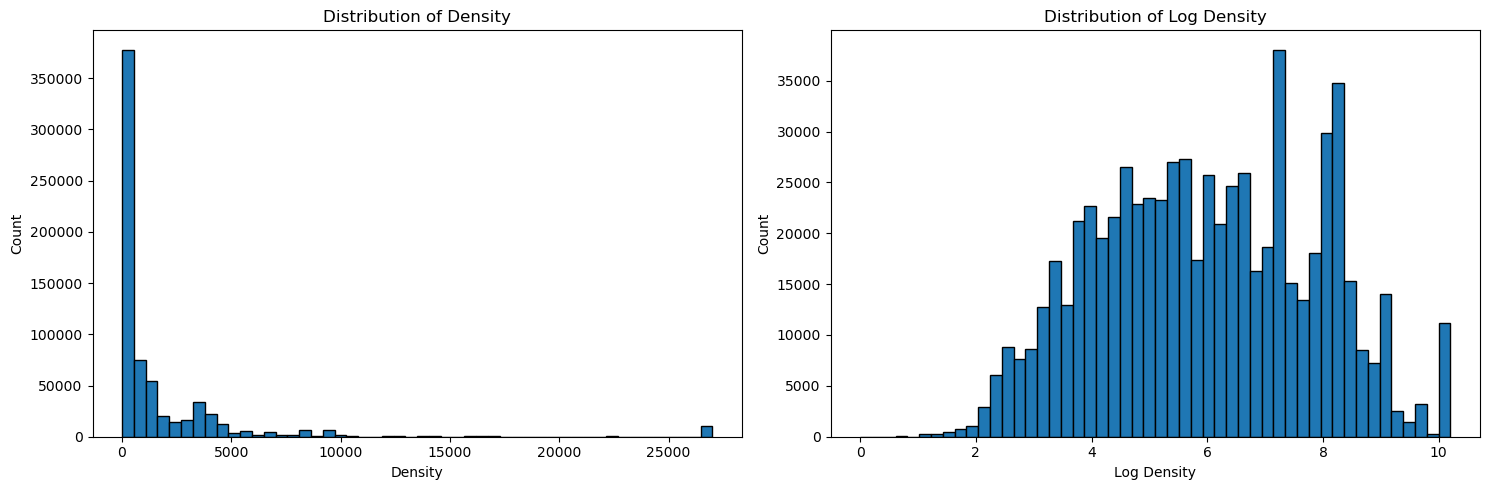

In [495]:
# Plot histograms of density and log density
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original density histogram
ax1.hist(df['Density'], bins=50, edgecolor='black')
ax1.set_title('Distribution of Density')
ax1.set_xlabel('Density')
ax1.set_ylabel('Count')

# Log density histogram
ax2.hist(np.log(df['Density']), bins=50, edgecolor='black')
ax2.set_title('Distribution of Log Density')
ax2.set_xlabel('Log Density')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()



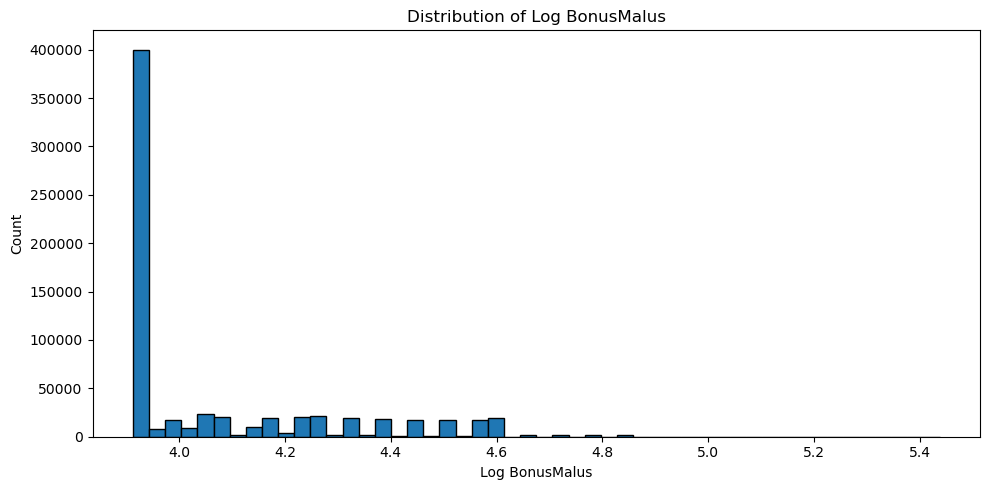

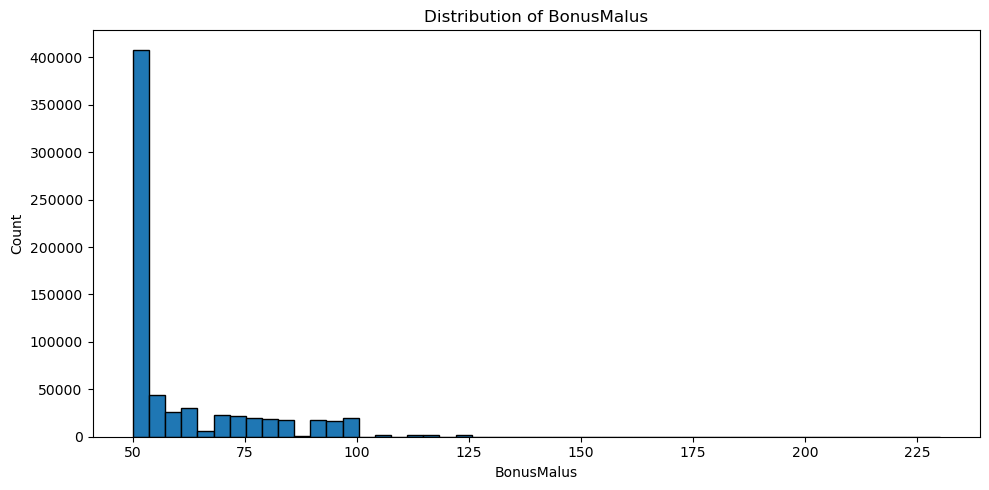

In [500]:
# Plot histogram of log BonusMalus
plt.figure(figsize=(10, 5))
plt.hist(np.log(df['BonusMalus']), bins=50, edgecolor='black')
plt.title('Distribution of Log BonusMalus')
plt.xlabel('Log BonusMalus')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot original BonusMalus distribution
plt.figure(figsize=(10, 5))
plt.hist(df['BonusMalus'], bins=50, edgecolor='black')
plt.title('Distribution of BonusMalus')
plt.xlabel('BonusMalus')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



In [525]:
numeric_cols = ["BonusMalus", "Density"]
preprocessor = ColumnTransformer(
    transformers=[
        ("bonusmalus", Pipeline([
            ("scaler", StandardScaler()),
            ("spline", SplineTransformer(n_knots=3, degree=3, knots="quantile", include_bias=False))
        ]), ["BonusMalus"]),
        ("density", Pipeline([
            ("log", FunctionTransformer(np.log)),
            ("scaler", StandardScaler()),
            ("spline", SplineTransformer(n_knots=3, degree=3, knots="quantile", include_bias=False))
        ]), ["Density"]),
        ("cat", OneHotEncoder(sparse_output=False, drop="first"), categoricals),
    ]
)
preprocessor.set_output(transform="pandas")
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimate", GeneralizedLinearRegressor(family=TweedieDist, l1_ratio=1, fit_intercept=True, max_iter=1000))
])
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bonusmalus',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('spline',
                                                                   SplineTransformer(include_bias=False,
                                                                                     knots='quantile',
                                                                                     n_knots=3))]),
                                                  ['BonusMalus']),
                                                 ('density',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('spline',
                                                                   SplineTransformer(include_bias=False,
                                                                                     knots='quantile',
                                                                                     n_knots=3))]),
                                                  ['Density']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['VehBrand', 'VehGas',
                                                   'Region', 'Area', 'DrivAge',
                                                   'VehAge', 'VehPower'])])),
                ('estimate',
                 GeneralizedLinearRegressor(family=<glum._distribution.TweedieDistribution object at 0x45dbff4d0>,
                                            l1_ratio=1, max_iter=1000))])

In [511]:
# let's check that the transforms worked
model_pipeline[:-1].fit_transform(df_train)

,bonusmalus__BonusMalus_sp_0,bonusmalus__BonusMalus_sp_1,bonusmalus__BonusMalus_sp_2,bonusmalus__BonusMalus_sp_3,bonusmalus__BonusMalus_sp_4,density__Density_sp_0,density__Density_sp_1,density__Density_sp_2,density__Density_sp_3,density__Density_sp_4,...,cat__DrivAge_4,cat__DrivAge_5,cat__DrivAge_6,cat__VehAge_1,cat__VehAge_2,cat__VehPower_5,cat__VehPower_6,cat__VehPower_7,cat__VehPower_8,cat__VehPower_9
0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053904,0.739567,0.206143,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.078717,0.890726,0.030413,0.000144,0.000000,0.000000,0.000000,0.117654,0.642542,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.651585,0.325269,0.022926,0.001362,0.130821,0.632705,0.235112,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.000000,0.830918,0.164658,0.004417,0.000952,0.116990,0.626319,0.255740,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.000000,0.876508,0.121309,0.002183,0.000000,0.000000,0.039837,0.712967,0.246027,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542405,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000029,0.127223,0.777857,0.094890,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
542406,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018017,0.469529,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
542407,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105359,0.635435,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
542408,0.0,0.000000,0.730750,0.256507,0.012672,0.000000,0.000000,0.000000,0.018017,0.469529,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [526]:
model_pipeline.fit(df_train, y_train_t, estimate__sample_weight=w_train_t)

pd.DataFrame(
    {
        "coefficient": np.concatenate(
            ([model_pipeline[-1].intercept_], model_pipeline[-1].coef_)
        )
    },
    index=["intercept"] + model_pipeline[-1].feature_names_,
).T

df_test["pp_t_glm2"] = model_pipeline.predict(df_test)
df_train["pp_t_glm2"] = model_pipeline.predict(df_train)

print(
    "training loss t_glm2:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_glm2"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_glm2:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_glm2"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df["ClaimAmountCut"].values[test].sum(),
        np.sum(df["Exposure"].values[test] * df_test["pp_t_glm2"]),
    )
)

/Users/congminhnguyen/miniconda/envs/ps3/lib/python3.12/site-packages/glum/_solvers.py:58: ConvergenceWarning: Coordinate descent did not converge. You might want to increase the number of iterations. Minimum norm subgradient: 0.0007248403008225673, tolerance: 0.0001
  new_coef, gap, _, _, n_cycles = enet_coordinate_descent_gram(


training loss t_glm2:  73.95174000474341
testing loss t_glm2:  72.25839684031118
Total claim amount on test set, observed = 9622405.67, predicted = 9958967.458245113


/Users/congminhnguyen/miniconda/envs/ps3/lib/python3.12/site-packages/glum/_solvers.py:58: ConvergenceWarning: Coordinate descent did not converge. You might want to increase the number of iterations. Minimum norm subgradient: 0.0007248402971469464, tolerance: 0.0001
  new_coef, gap, _, _, n_cycles = enet_coordinate_descent_gram(
/Users/congminhnguyen/miniconda/envs/ps3/lib/python3.12/site-packages/glum/_solvers.py:58: ConvergenceWarning: Coordinate descent did not converge. You might want to increase the number of iterations. Minimum norm subgradient: 0.0006142948480494416, tolerance: 0.0001
  new_coef, gap, _, _, n_cycles = enet_coordinate_descent_gram(
/Users/congminhnguyen/miniconda/envs/ps3/lib/python3.12/site-packages/glum/_solvers.py:58: ConvergenceWarning: Coordinate descent did not converge. You might want to increase the number of iterations. Minimum norm subgradient: 0.0004783182438944347, tolerance: 0.0001
  new_coef, gap, _, _, n_cycles = enet_coordinate_descent_gram(
/Use

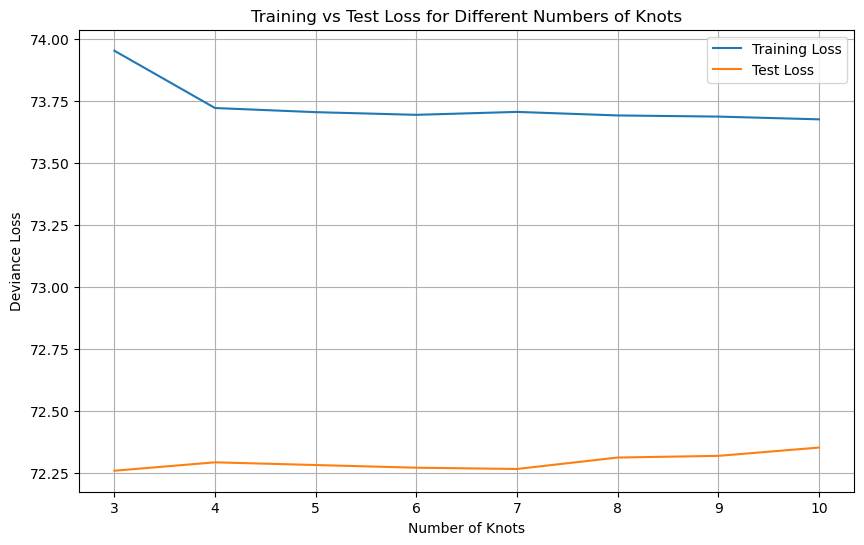

In [527]:
# Plot training and test loss for different numbers of knots to check for overfitting
knots_range = range(3, 11)
train_losses = []
test_losses = []

for n_knots in knots_range:
    # Create pipeline with current number of knots
    preprocessor = ColumnTransformer(
        transformers=[
            ("bonusmalus", Pipeline([
                ("scaler", StandardScaler()),
                ("spline", SplineTransformer(n_knots=n_knots, degree=3, knots="quantile", include_bias=False))
            ]), ["BonusMalus"]),
            ("density", Pipeline([
                ("log", FunctionTransformer(np.log)),
                ("scaler", StandardScaler()),
                ("spline", SplineTransformer(n_knots=n_knots, degree=3, knots="quantile", include_bias=False))
            ]), ["Density"]),
            ("cat", OneHotEncoder(sparse_output=False, drop="first"), categoricals),
        ]
    )
    preprocessor.set_output(transform="pandas")
    
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("estimate", GeneralizedLinearRegressor(family=TweedieDist, l1_ratio=1, fit_intercept=True, max_iter=1000))
    ])
    
    # Fit model and get predictions
    model.fit(df_train, y_train_t, estimate__sample_weight=w_train_t)
    train_pred = model.predict(df_train)
    test_pred = model.predict(df_test)
    
    # Calculate losses
    train_loss = TweedieDist.deviance(y_train_t, train_pred, sample_weight=w_train_t) / np.sum(w_train_t)
    test_loss = TweedieDist.deviance(y_test_t, test_pred, sample_weight=w_test_t) / np.sum(w_test_t)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(knots_range, train_losses, label='Training Loss')
plt.plot(knots_range, test_losses, label='Test Loss')
plt.xlabel('Number of Knots')
plt.ylabel('Deviance Loss')
plt.title('Training vs Test Loss for Different Numbers of Knots')
plt.legend()
plt.grid(True)
plt.show()

**Assessment of Overfitting:** Looking at this plot of training vs test loss across different numbers of knots, we can make several observations:
- Training loss (blue line) is consistently higher than test loss (orange line)
- The test loss is minimized when the number of knots is 3, which is the number of knots we used in our initial model.
- The test loss increases as the number of knots increases beyond 3, indicating overfitting.


## Improvement 2: LGBM Regressor

In [546]:
model_pipeline_lgbm = Pipeline([
    ("estimate", LGBMRegressor(
        objective='tweedie',  # Using tweedie objective for insurance claims
        tweedie_variance_power=1.5,  # Common value for insurance claims
        n_estimators=50,
        learning_rate=0.05
    ))
])

model_pipeline_lgbm.fit(X_train_t, y_train_t, estimate__sample_weight=w_train_t)
df_test["pp_t_lgbm"] = model_pipeline_lgbm.predict(X_test_t)
df_train["pp_t_lgbm"] = model_pipeline_lgbm.predict(X_train_t)

print(
    "training loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_lgbm"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_lgbm"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 10
[LightGBM] [Info] Start training from score 4.930187
training loss t_lgbm:  69.770474942285
testing loss t_lgbm:  71.8217447033684


In [549]:
cv = GridSearchCV(
    estimator=LGBMRegressor(
        objective='tweedie',
        tweedie_variance_power=1.5
    ),
    param_grid={
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 200]
    },
    cv=5,
    scoring='neg_mean_squared_error'
)

# Fit the grid search
cv.fit(X_train_t, y_train_t, sample_weight=w_train_t)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 433928, number of used features: 10
[LightGBM] [Info] Start training from score 4.923918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 433928, number of used features: 10
[LightGBM] [Info] Start training from score 4.933071
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [552]:
# Use best model for predictions
print("Best parameters:", cv.best_params_)
print("Best CV score:", cv.best_score_)

df_test["pp_t_lgbm"] = cv.best_estimator_.predict(X_test_t)
df_train["pp_t_lgbm"] = cv.best_estimator_.predict(X_train_t)

train_loss = TweedieDist.deviance(y_train_t, df_train["pp_t_lgbm"], sample_weight=w_train_t) / np.sum(w_train_t)
test_loss = TweedieDist.deviance(y_test_t, df_test["pp_t_lgbm"], sample_weight=w_test_t) / np.sum(w_test_t)

print(f"training loss t_lgbm: {train_loss:.6f}")
print(f"testing loss t_lgbm: {test_loss:.6f}")

observed = df["ClaimAmountCut"].values[test].sum()
predicted = np.sum(df["Exposure"].values[test] * df_test["pp_t_lgbm"])

print(
    "Total claim amount on test set, observed = {:.2f}, predicted = {:.2f}".format(
        observed, predicted
    )
)

Best parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best CV score: -206348521.13349125
training loss t_lgbm: 67.765198
testing loss t_lgbm: 71.791930
Total claim amount on test set, observed = 9622405.67, predicted = 8797478.08


## Final Model: Lorenz Curve

[]

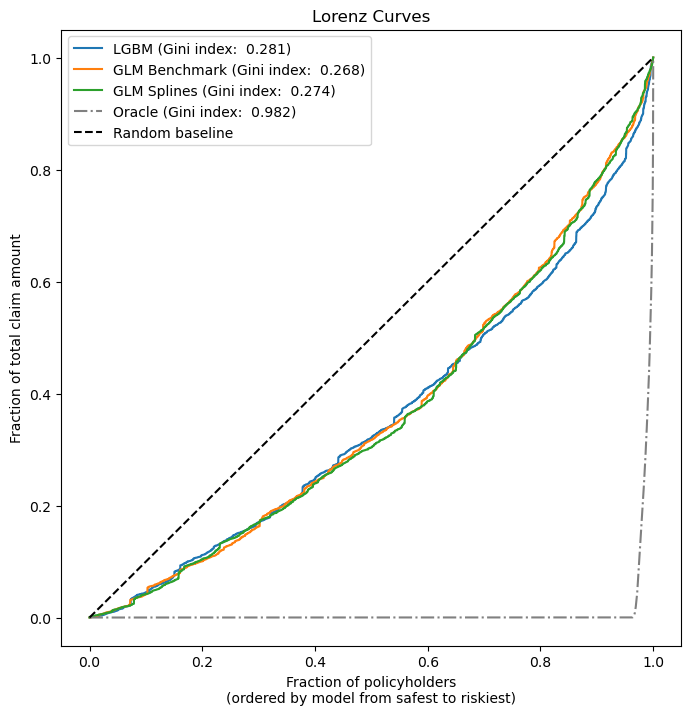

In [562]:
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

for label, y_pred in [
    ("LGBM", df_test["pp_t_lgbm"]),
    ("GLM Benchmark", df_test["pp_t_glm1"]),
    ("GLM Splines", df_test["pp_t_glm2"]),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += f" (Gini index: {gini: .3f})"
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = f"Oracle (Gini index: {gini: .3f})"
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()

- All models perform better than the random baseline, indicating that they are able to capture some of the variation in the data.
- The GLM with splines performs slightly better than the GLM benchmark, indicating that the additional flexibility in the model structure is beneficial.
- The LGBM model performs the best among the three in the sense that it has the highest discriminative power (Gini index). The blue line (LGBM) shows better separation from other models especially in the higher risk ranges (right side of the curve), which can be more important for the company.
